In [1]:
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
from os.path import join as oj
import pandas as pd
import pickle as pkl
import models
import util
import os
import config
import torch
import viz
from tqdm import tqdm
import figs
import matplotlib.image as mpimg
import seaborn as sns
import data
from copy import deepcopy
import sklearn.metrics
from matching import *

import cv2
import torch
from torch import nn
# from models import LinkNet34
import torchvision.transforms as transforms
from torch.autograd import Variable
import sys
from PIL import Image, ImageFilter
from face_segmentation.models import LinkNet34

DIR_ORIG = '../data/celeba-hq/ims/'
DIR_GEN = oj('../data_processed/celeba-hq/generated_images_0.1')


# df contains filenames, ids, and attributes
df = data.load_all_labs()
df = df.set_index('fname_id')
# df = df[['id', 'fname_final', 'age', 'gender', 'race_pred', 'race4_pred', 'Eyeglasses']] # only keep few keys to speed things up

loading cached labels


In [9]:
from PIL import Image
import torchvision.transforms.functional as TF
fname = '/home/ubuntu/face-disentanglement/data/celeba-hq/ims/00001.jpg'

In [16]:
image = Image.open(fname)
# x = TF.to_tensor(image)
# x = x.unsqueeze_(0)

In [18]:
x.shape

torch.Size([1, 3, 1024, 1024])

In [21]:
transformations(image).shape

torch.Size([3, 224, 224])

# set up for face segmentation

In [24]:
# get face seg model
device = torch.device('cpu') #"cuda:0" if torch.cuda.is_available() else "cpu")
model = LinkNet34()
model.load_state_dict(torch.load('face_segmentation/linknet.pth', map_location=lambda storage, loc: storage))
model.eval()
model.to(device)

# setup for face segmentation
img_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
])
t = transforms.Resize(size=(256,256))

def smooth_mask(mask):
    im = Image.fromarray(mask)
    im2 = im.filter(ImageFilter.MinFilter(3))
    im3 = im2.filter(ImageFilter.MaxFilter(5))
    return np.array(im3)

def get_mask(path, plot=True):
    _img = Image.open(path)
    a = img_transform(_img)
    a = a.unsqueeze(0)
    imgs = a.to(device)
    pred = model(imgs)
    img = np.array(_img)
    mask = pred > 0.5
    mask = mask.squeeze()
    mask = mask.cpu().numpy()
    img = np.array(t(Image.fromarray(img)))
    if plot:
        img[mask==0] = 170
        util.imshow(img)
    return mask, img

# test on one image

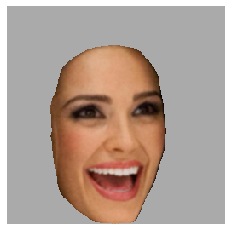

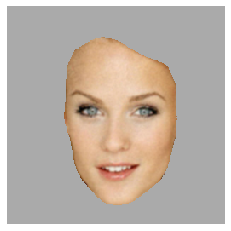

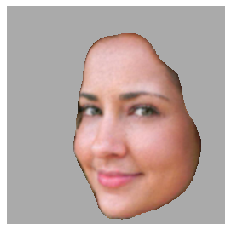

In [26]:
for i in range(3):
    fname = oj(DIR_ORIG, df.iloc[i].fname_final)
    file_path = oj(fname)
    model.eval()
    mask, img = get_mask(file_path) # mask is True for face, false otherwise
    plt.show()

In [35]:
r = {
    k: [] for k in ['mean', 'std']
}
for i in tqdm(range(df.shape[0])):
    fname = oj(DIR_ORIG, df.iloc[i].fname_final)
    mask, img = get_mask(file_path, plot=False) # mask is True for face, false otherwise
    background = img[~mask]
    r['mean'].append(background.mean())
    r['std'].append(background.std())
# pd.DataFrame(r).to_pickle('processed/15_background_stats.pkl')

100%|██████████| 30000/30000 [2:22:50<00:00,  3.50it/s]  


# look at the resulting feats

In [ ]:
C = 8
for k in ['background_mean', 'background_std', 'quality'] + [k for k in df.keys() if 'prob' in k]:
    idxs = [int(i / C * df.shape[0]) for i in range(C)] + [df.shape[0] - 1]
    d = df.sort_values(k).iloc[idxs]
    ims = [mpimg.imread(oj(DIR_ORIG, f)) for f in d.fname_final]
    vals = d[k].round(2)
    util.plot_row(ims, annot_list=vals, ylab=k)